# Chapter 19. Overfitting 의 위험성

# What is overfitting?

When constructing a model, we tune both the parameters and the model by fitting to sample data. We then use the model and parameters to predict data we have not yet observed. We say a model is overfit when it is overly sensitive to noise and idiosyncracies in the sample data, and therefore does not reflect the underlying data-generating process.

To understand why this happens, one has to consider the amount of noise present in any dataset. One can consider a set of data as $D_{T}$, the true underlying data that came from whatever process we are trying to model, and $\epsilon$, some random noise. Because what we see is $D = D_{T} + \epsilon$, we might fit out model to very perfectly predict for the given $\epsilon$, but not for $D_{T}$.

This is problematic because we only care about fitting to the sample insofar as that gives an accurate fit to future data. The two broad causes of overfitting are:
* small sample size, so that noise and trend are not distinguishable
* choosing an overly complex model, so that it ends up contorting to fit the noise in the sample

##Verbal Example: Too Many Rules (Complexity)

Let's say you have the following dataset:

| TV Channel | Room Lighting Intensity | Enjoyment |
|------------|-------------------------|-----------|
| 1          | 2                       | 1         |
| 2          | 3                       | 2         |
| 3          | 1                       | 3         |

You are trying to predict enjoyment, so you create the following rules:

1. If TV Channel is 1 and Lighting Intensity is 2, then Enjoyment will be 1.
2. If TV Channel is 2 and Lighting Intensity is 3, then Enjoyment will be 2.
3. If TV Channel is 3 and Lighting Intensity is 1, then Enjoyment will be 3.
4. In all other cases predict an average enjoyment of 2.

This is a well defined model for future data, however, in this case let's say your enjoyment is purely dependent on the tv channel and not on the lighting. Because we have a rule for each row in our dataset, our model is perfectly predictive in our historical data, but would performly poorly in real trials because  we are overfitting to random noise in the lighting intensity data.

Generalizing this to stocks, if your model starts developing many specific rules based on specific past events, it is almost definitely overfitting. This is why black-box machine learning (neural networks, etc.) is so dangerous when not done correctly.

# Example: Curve fitting

Overfitting is most easily seen when we look at polynomial regression. Below we construct a dataset which noisily follows a quadratic. The linear model is underfit: simple linear models aren't suitable for all situations, especially when we have reason to believe that the data is nonlinear. The quadratic curve has some error but fits the data well.

When we fit a ninth-degree polynomial to the data, the error is zero - a ninth-degree polynomial can be constructed to go through any 10 points - but, looking at the tails of the curve, we know that we can't expect it to accurately predict other samples from the same distribution. It fits the data perfectly, but that is because it also fits the noise perfectly, and the noise is not what we want to model. In this case we have selected a model that is too complex.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels import regression
from scipy import poly1d

C:\Users\trimu\Miniconda3\envs\py36_32\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


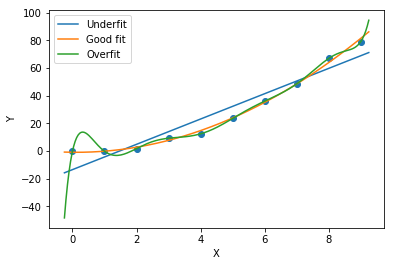

In [5]:
x = np.arange(10)
y = 2*np.random.randn(10) + x**2
xs = np.linspace(-0.25, 9.25, 200)

lin = np.polyfit(x, y, 1)
quad = np.polyfit(x, y, 2)
many = np.polyfit(x, y, 9)

plt.scatter(x, y)
plt.plot(xs, poly1d(lin)(xs))
plt.plot(xs, poly1d(quad)(xs))
plt.plot(xs, poly1d(many)(xs))
plt.ylabel('Y')
plt.xlabel('X')
plt.legend(['Underfit', 'Good fit', 'Overfit']);

When working with real data, there is unlikely to ever be a situation where a ninth-degree polynomial is appropriate: our choice of function should reflect a belief about the underlying process, and real-world processes generally do not follow high-degree polynomial curves. This example is contrived, but it can be tempting to use a quadratic or cubic model just to decrease sample error.

##Note: Model/Parameter Parsimony

Just as the most elegant physics models describe a tremendous amount of our world through a few equations, a good trading model should explain most of the data through a few rules. Any time you start to have a number of rules even close to the number of points in your data set, you can be sure you are overfitting. Since parameters can be thought of as rules as they equivalently constrain a model, the same is true of parameters. Fewer parameters is better, and it is better to explain 60% of the data with 2-3 paremeters than 90% with 10.

##Beware of the perfect fit

Because there is almost always noise present in real data, a perfect fit is almost always indicative of overfitting. It is almost impossible to know the percentage noise/signal in a given data set while you are developing the model, but use your common sense. Are the predictions surprisingly good? Then you're probably overfitting.

# Example: Regression parameters

How do we know which variables to include in a model? If we're afraid of omitting something important, we might try different ones and include all the variables we can find that improve the fit. Below we regress one asset that is in the same sector as the asset whose price we're trying to predict, and three other unrelated ones. In our initial timeframe, we are able to fit the model more closely to the data when using multiple variables than when using just one.

SLR R-squared: 0.7293161341744352
SLR p-value: 4.085124876887202e-73
MLR R-squared: 0.8312076168552329
MLR p-value: 5.412797634770279e-95


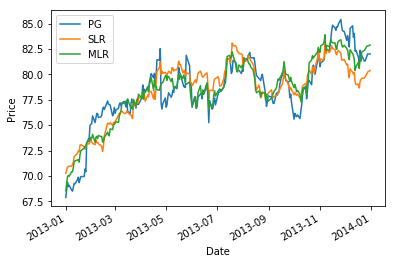

In [6]:
# Load one year's worth of pricing data for five different assets

from googlefinance.client import get_price_data, get_prices_data
import pandas as pd

start = pd.to_datetime('2013-01-01')
end = pd.to_datetime('2014-01-01')
df = pd.DataFrame(get_price_data({'q': "PEP", 'i': "86400", 'x': "NASD", 'p': "10Y" }))['Close'].loc[start : end]
df.index = pd.to_datetime(df.index.date)
x1 = df
df = pd.DataFrame(get_price_data({'q': "MCD", 'i': "86400", 'x': "NYSE", 'p': "10Y" }))['Close'].loc[start : end]
df.index = pd.to_datetime(df.index.date)
x2 = df
df = pd.DataFrame(get_price_data({'q': "ATHN", 'i': "86400", 'x': "NASD", 'p': "10Y" }))['Close'].loc[start : end]
df.index = pd.to_datetime(df.index.date)
x3 = df
df = pd.DataFrame(get_price_data({'q': "PG", 'i': "86400", 'x': "NYSE", 'p': "10Y" }))['Close'].loc[start : end]
df.index = pd.to_datetime(df.index.date)
y = df
start = pd.to_datetime('2013-01-01')
end = pd.to_datetime('2013-12-31')
df = get_prices_data( [{'q': ".INX", 'x': "INDEXSP",}], "10Y")
df.index = pd.to_datetime(df.index)
df = df['.INX_Close'].loc[start:end]
x4 = df

#Build a linear model using only x1 to explain y
slr = regression.linear_model.OLS(y, sm.add_constant(x1)).fit()
slr_prediction = slr.params[0] + slr.params[1]*x1

# Run multiple linear regression using x1, x2, x3, x4 to explain y
mlr = regression.linear_model.OLS(y, sm.add_constant(np.column_stack((x1,x2,x3,x4)))).fit()
mlr_prediction = mlr.params[0] + mlr.params[1]*x1 + mlr.params[2]*x2 + mlr.params[3]*x3 + mlr.params[4]*x4

# Compute adjusted R-squared for the two different models
print('SLR R-squared:', slr.rsquared_adj)
print('SLR p-value:', slr.f_pvalue)
print('MLR R-squared:', mlr.rsquared_adj)
print('MLR p-value:', mlr.f_pvalue)

# Plot y along with the two different predictions
y.plot()
slr_prediction.plot()
mlr_prediction.plot()
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(['PG', 'SLR', 'MLR']);

위에서 PG 종목의 가격을 예측하는데에 SLR 은 PEP 종목만으로 SLR 을 하고, MLR 은 3 개 종목과 SPY 를 포함한 MLR  을 한 경우 둘 다 잘 fit 되어 보이지만 time period 를 다르게 할 경우 single-variable model 은 잘 안 맞고 multiple-variable model 은 완전히 useless 해 진다. 위에서 찾아낸 relationship 이 inconsistent 하고 original sample data 에 특화된 것으로 보인다.

SLR R-squared: 0.40588850307820046
MLR R-squared: -0.3492366741357653


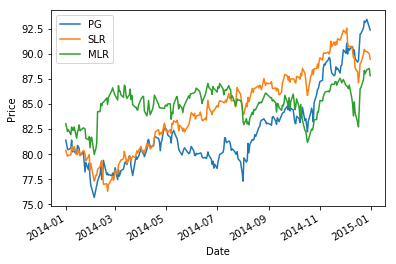

In [7]:
# Load the next of pricing data
start = pd.to_datetime('2014-01-01')
end = pd.to_datetime('2015-01-01')
df = pd.DataFrame(get_price_data({'q': "PEP", 'i': "86400", 'x': "NASD", 'p': "10Y" }))['Close'].loc[start : end]
df.index = pd.to_datetime(df.index.date)
x1 = df
df = pd.DataFrame(get_price_data({'q': "MCD", 'i': "86400", 'x': "NYSE", 'p': "10Y" }))['Close'].loc[start : end]
df.index = pd.to_datetime(df.index.date)
x2 = df
df = pd.DataFrame(get_price_data({'q': "ATHN", 'i': "86400", 'x': "NASD", 'p': "10Y" }))['Close'].loc[start : end]
df.index = pd.to_datetime(df.index.date)
x3 = df
df = pd.DataFrame(get_price_data({'q': "PG", 'i': "86400", 'x': "NYSE", 'p': "10Y" }))['Close'].loc[start : end]
df.index = pd.to_datetime(df.index.date)
y = df
start = pd.to_datetime('2014-01-01')
end = pd.to_datetime('2014-12-31')
df = get_prices_data( [{'q': ".INX", 'x': "INDEXSP",}], "10Y")
df.index = pd.to_datetime(df.index)
df = df['.INX_Close'].loc[start:end]
x4 = df
# Extend our model from before to the new time period
slr_prediction2 = slr.params[0] + slr.params[1]*x1
mlr_prediction2 = mlr.params[0] + mlr.params[1]*x1 + mlr.params[2]*x2 + mlr.params[3]*x3 + mlr.params[4]*x4

# Manually compute adjusted R-squared over the new time period

# Adjustment 1 is for the SLR model
p = 1
N = len(y)
adj1 = float(N - 1)/(N - p - 1)

# Now for MLR
p = 4
N = len(y)
adj2 = float(N - 1)/(N - p - 1)

SST = sum((y - np.mean(y))**2)
SSRs = sum((slr_prediction2 - y)**2)
print('SLR R-squared:', 1 - adj1*SSRs/SST)
SSRm = sum((mlr_prediction2 - y)**2)
print('MLR R-squared:', 1 - adj2*SSRm/SST)

# Plot y along with the two different predictions
y.plot()
slr_prediction2.plot()
mlr_prediction2.plot()
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(['PG', 'SLR', 'MLR']);

If we wanted, we could scan our universe for variables that were correlated with the dependent variable, and construct an extremely overfitted model. However, in most cases the correlation will be spurious, and the relationship will not continue into the future.

# Example: Rolling windows

이동평균 혹은 이동 beta 와 같이 rolling parameter 를 계산하는 모델에서 window length 선택은 쉽지 않은 문제이다.

긴 window 는 long-term trend 를 표시하고 덜 volatile 하지만, 새로운 관측 결과를 반영하는 time lag 이 길어진다. window length 선택은 rolling parameter 계산에 강한 영향을 미치고 우리가 data 를 다루는 방식을 바꿀 수 있다. 아래는 다른 window length 에 대한 주가의 rolling average 계산을 예시이다.

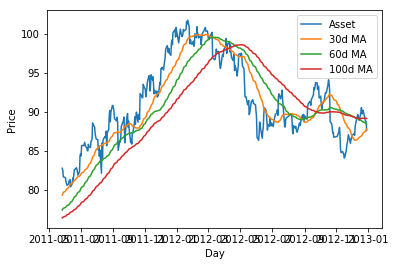

In [8]:
# Load the pricing data for a stock

start = pd.to_datetime('2011-01-01')
end = pd.to_datetime('2013-01-01')
df = pd.DataFrame(get_price_data({'q': "MCD", 'i': "86400", 'x': "NYSE", 'p': "10Y" }))['Close'].loc[start : end]
df.index = pd.to_datetime(df.index.date)
pricing = df

# Compute rolling averages for various window lengths
mu_30d = pricing.rolling(window=30).mean()
mu_60d = pricing.rolling(window=60).mean()
mu_100d = pricing.rolling(window=100).mean()

# Plot asset pricing data with rolling means from the 100th day, when all the means become available
plt.plot(pricing[100:], label='Asset')
plt.plot(mu_30d[100:], label='30d MA')
plt.plot(mu_60d[100:], label='60d MA')
plt.plot(mu_100d[100:], label='100d MA')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend();

알고리즘이 가장 잘 들어맞는 length 를 선택할 경우, overfitting 이다. 아래의 예는 window length 에 따라 algorithm performance 를 측정하여 best one 을 고르는데 timeframe 이 달라지면 결과가 달라지는 것을 알 수 있다. 이뉴는 원래의 선택이 sample data 에 overfitting 되었기 때문이다.

In [9]:
# Trade using a simple mean-reversion strategy
def trade(stock, length):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if length == 0:
        return 0
    
    # Compute rolling mean and rolling standard deviation
    rolling_window = stock.rolling(window=length)
    mu = rolling_window.mean()
    std = rolling_window.std()
    
    # Compute the z-scores for each day using the historical data up to that day
    zscores = (stock - mu)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    count = 0
    for i in range(len(stock)):
        # Sell short if the z-score is > 1
        if zscores[i] > 1:
            money += stock[i]
            count -= 1
        # Buy long if the z-score is < 1
        elif zscores[i] < -1:
            money -= stock[i]
            count += 1
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscores[i]) < 0.5:
            money += count*stock[i]
            count = 0
    return money

In [10]:
# Find the window length 0-254 that gives the highest returns using this strategy
length_scores = [trade(pricing, l) for l in range(255)]
best_length = np.argmax(length_scores)
print('Best window length:', best_length)

Best window length: 11


In [11]:
# Get pricing data for a different timeframe
start = pd.to_datetime('2013-01-01')
end = pd.to_datetime('2015-01-01')
df = pd.DataFrame(get_price_data({'q': "MCD", 'i': "86400", 'x': "NYSE", 'p': "10Y" }))['Close'].loc[start : end]
df.index = pd.to_datetime(df.index.date)
pricing2 = df
# Find the returns during this period using what we think is the best window length
length_scores2 = [trade(pricing2, l) for l in range(255)]
print(best_length, 'day window:', length_scores2[best_length])

# Find the best window length based on this dataset, and the returns using this window length
best_length2 = np.argmax(length_scores2)
print(best_length2, 'day window:', length_scores2[best_length2])

11 day window: 416.99000000000007
189 day window: 471.27999999999895


Clearly fitting to our sample data doesn't always give good results in the future. Just for fun, let's plot the length scores computed from the two different timeframes:

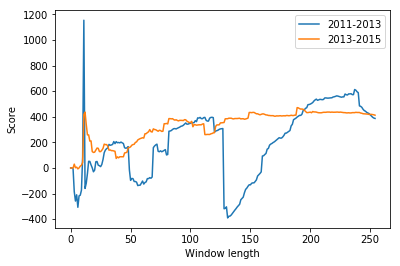

In [12]:
plt.plot(length_scores)
plt.plot(length_scores2)
plt.xlabel('Window length')
plt.ylabel('Score')
plt.legend(['2011-2013', '2013-2015']);

overfitting 을 피하기 위해서 window 길이 선택에 economic reasoning 이나 알고리즘의 nature 를 사용할 수 있다. 또한 길이 지정을 요구하지 않는 Kalman filters 를 사용할 수 동 있다.

# Avoiding overfitting

large samples 사용, 납득할 수 있는 단순한 모델 선택, data 를 fit 하기 위한 손쉬운 parameter 선택하지 않기 등을 하여도 두번의 backtest 만 이미 overfitting 된 것이다. 

## Out of Sample Testing

overfitting 되지 않았음을 확인하려면 반드시 out of sample test 를 해야 한다. 모델 구축 시 사용하지 않았던 data 를 모아서 모델이 여전히 잘 작동하는지 테스트한다. large data 를 구할 수 없으면 dataset 을 split 해야 한다.

### Common Mistake: Abusing Out of Sample Data

Sometimes people will construct a model on in-sample data, test on out-of-sample data, and conclude it doesn't work. They will then repeat this process until they find a model that works. This is still overfitting, as you have no overfit the model to the out-of-sample data by using it many times, and when you actually test on true out-of-sample data your model will likely break down.

### Cross Validation

Cross validation is the process of splitting your data into n parts, then estimating optimal parameters for n-1 parts combined and testing on the final part. By doing this n times, one for each part held out, we can establish how stable our parameter estimates are and how predictive they are on data not from the original set.